In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                            precision_recall_curve, average_precision_score)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import roc_auc_score, RocCurveDisplay

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [21]:
# Load data into a dataframe
subsidy = pd.read_excel('subsidy.xlsx', sheet_name='subsidy_disbursements')

National_ID  Age  Gender Region Income_Level  Household_Dependents  \
0         ID00001   56    Male  Lagos          Low                     4   
1         ID00001   56    Male  Lagos          Low                     4   
2         ID00001   56    Male  Lagos          Low                     4   
3         ID00001   56    Male  Lagos          Low                     4   
4         ID00001   56    Male  Lagos          Low                     4   
...           ...  ...     ...    ...          ...                   ...   
80020     ID10000   32  Female  Lagos          Low                     6   
80021     ID10000   32  Female  Lagos          Low                     6   
80022     ID10000   32  Female  Lagos          Low                     6   
80023     ID10000   32  Female  Lagos          Low                     6   
80024     ID10000   32  Female  Lagos          Low                     6   

       Monthly_Energy_Consumption_kWh  Subsidy_Eligibility   Subsidy_Type  \
0                                 151                    1           Food   
1                                 151                    1           Food   
2                                 151                    1           Food   
3                                 151                    1  Cash Transfer   
4                                 151                    1           Food   
...                               ...                  ...            ...   
80020                              94                    1  Cash Transfer   
80021                              94                    1           Food   
80022                              94                    1           Fuel   
80023                              94                    1           Fuel   
80024                              94                    1           Fuel   

       Amount (NGN)        Channel       Date Wallet_Activity_Status  \
0              2977  Mobile Wallet 2022-01-04                 Active   
1              2689   Bank Account 2020-12-20                    NaN   
2              3251  Mobile Wallet 2022-06-05                 Active   
3              6065  Mobile Wallet 2021-05-23                 Active   
4              3201  Mobile Wallet 2023-09-17               Inactive   
...             ...            ...        ...                    ...   
80020          8166   Bank Account 2019-01-25                    NaN   
80021          2704  Mobile Wallet 2021-03-02                 Active   
80022          4243    Cash Pickup 2021-04-23                    NaN   
80023          5404   Bank Account 2022-02-19                    NaN   
80024          5728   Bank Account 2022-08-04                    NaN   

       Wallet_Balance (NGN)  Days_Since_Last_Transaction  \
0                    4373.0                         16.0   
1                       NaN                          NaN   
2                    3353.0                         76.0   
3                    5090.0                         55.0   
4                    7870.0                          3.0   
...                     ...                          ...   
80020                   NaN                          NaN   
80021                2031.0                         17.0   
80022                   NaN                          NaN   
80023                   NaN                          NaN   
80024                   NaN                          NaN   

       Avg_Monthly_Wallet_Balance  Suspected_Fraud  
0                          5986.0                0  
1                             NaN                0  
2                          2276.0                0  
3                          4347.0                0  
4                          5906.0                0  
...                           ...              ...  
80020                         NaN                0  
80021                        94.0                0  
80022                         NaN                0  
80023                         NaN                0  

In [5]:
# Check for data types
subsidy.dtypes

National_ID                               object
Age                                        int64
Gender                                    object
Region                                    object
Income_Level                              object
Household_Dependents                       int64
Monthly_Energy_Consumption_kWh             int64
Subsidy_Eligibility                        int64
Subsidy_Type                              object
Amount (NGN)                               int64
Channel                                   object
Date                              datetime64[ns]
Wallet_Activity_Status                    object
Wallet_Balance (NGN)                     float64
Days_Since_Last_Transaction              float64
Avg_Monthly_Wallet_Balance               float64
Suspected_Fraud                            int64
dtype: object

In [6]:
# Checking for missing values in the dataset
subsidy.isnull().sum()

National_ID                           0
Age                                   0
Gender                                0
Region                                0
Income_Level                          0
Household_Dependents                  0
Monthly_Energy_Consumption_kWh        0
Subsidy_Eligibility                   0
Subsidy_Type                          0
Amount (NGN)                          0
Channel                               0
Date                                  0
Wallet_Activity_Status            53337
Wallet_Balance (NGN)              53337
Days_Since_Last_Transaction       53337
Avg_Monthly_Wallet_Balance        53337
Suspected_Fraud                       0
dtype: int64

In [7]:
# Checking for duplicate rows in the dataset
duplicate_rows = subsidy.duplicated().sum()
duplicate_rows[duplicate_rows > 0]

array([], dtype=int64)

In [8]:
# Creating a copy of the subsidy DataFrame for visualisation and explaratoty data analysis
subsidy_clean = subsidy.copy()
# Filling missing values in 'Wallet_Acitivity_Status' with 'No Wallet
subsidy_clean['Wallet_Activity_Status'] = subsidy_clean['Wallet_Activity_Status'].fillna('No Wallet')
# Converting its data type from object to category
subsidy_clean['Wallet_Activity_Status'] = subsidy_clean['Wallet_Activity_Status'].astype('category')

In [9]:
wallet_activities=[
   'Wallet_Balance (NGN)',
   'Days_Since_Last_Transaction',
   'Avg_Monthly_Wallet_Balance'
]
subsidy_clean[wallet_activities] = subsidy[wallet_activities].fillna(0)

In [10]:
subsidy_clean.head()

National_ID  Age Gender Region Income_Level  Household_Dependents  \
0     ID00001   56   Male  Lagos          Low                     4   
1     ID00001   56   Male  Lagos          Low                     4   
2     ID00001   56   Male  Lagos          Low                     4   
3     ID00001   56   Male  Lagos          Low                     4   
4     ID00001   56   Male  Lagos          Low                     4   

   Monthly_Energy_Consumption_kWh  Subsidy_Eligibility   Subsidy_Type  \
0                             151                    1           Food   
1                             151                    1           Food   
2                             151                    1           Food   
3                             151                    1  Cash Transfer   
4                             151                    1           Food   

   Amount (NGN)        Channel       Date Wallet_Activity_Status  \
0          2977  Mobile Wallet 2022-01-04                 Active   
1          2689   Bank Account 2020-12-20              No Wallet   
2          3251  Mobile Wallet 2022-06-05                 Active   
3          6065  Mobile Wallet 2021-05-23                 Active   
4          3201  Mobile Wallet 2023-09-17               Inactive   

   Wallet_Balance (NGN)  Days_Since_Last_Transaction  \
0                4373.0                         16.0   
1                   0.0                          0.0   
2                3353.0                         76.0   
3                5090.0                         55.0   
4                7870.0                          3.0   

   Avg_Monthly_Wallet_Balance  Suspected_Fraud  
0                      5986.0                0  
1                         0.0                0  
2                      2276.0                0  
3                      4347.0                0  
4                      5906.0                0

In [11]:
# Rename columns
subsidy_clean.rename(columns={'Amount (NGN)': 'Amount_NGN', 'Wallet_Balance (NGN)': 'Wallet_Balance_NGN'}, inplace=True)

# Change Date column data type
subsidy_clean['Date'] = pd.to_datetime(subsidy_clean['Date'])

In [14]:
subsidy_clean.head()

National_ID  Age Gender Region Income_Level  Household_Dependents  \
0     ID00001   56   Male  Lagos          Low                     4   
1     ID00001   56   Male  Lagos          Low                     4   
2     ID00001   56   Male  Lagos          Low                     4   
3     ID00001   56   Male  Lagos          Low                     4   
4     ID00001   56   Male  Lagos          Low                     4   

   Monthly_Energy_Consumption_kWh  Subsidy_Eligibility   Subsidy_Type  \
0                             151                    1           Food   
1                             151                    1           Food   
2                             151                    1           Food   
3                             151                    1  Cash Transfer   
4                             151                    1           Food   

   Amount_NGN        Channel       Date Wallet_Activity_Status  \
0        2977  Mobile Wallet 2022-01-04                 Active   
1        2689   Bank Account 2020-12-20              No Wallet   
2        3251  Mobile Wallet 2022-06-05                 Active   
3        6065  Mobile Wallet 2021-05-23                 Active   
4        3201  Mobile Wallet 2023-09-17               Inactive   

   Wallet_Balance_NGN  Days_Since_Last_Transaction  \
0              4373.0                         16.0   
1                 0.0                          0.0   
2              3353.0                         76.0   
3              5090.0                         55.0   
4              7870.0                          3.0   

   Avg_Monthly_Wallet_Balance  Suspected_Fraud  
0                      5986.0                0  
1                         0.0                0  
2                      2276.0                0  
3                      4347.0                0  
4                      5906.0                0

In [13]:
df = subsidy_clean.copy()

# Exploratory Data Analysis

## Demographic Analysis

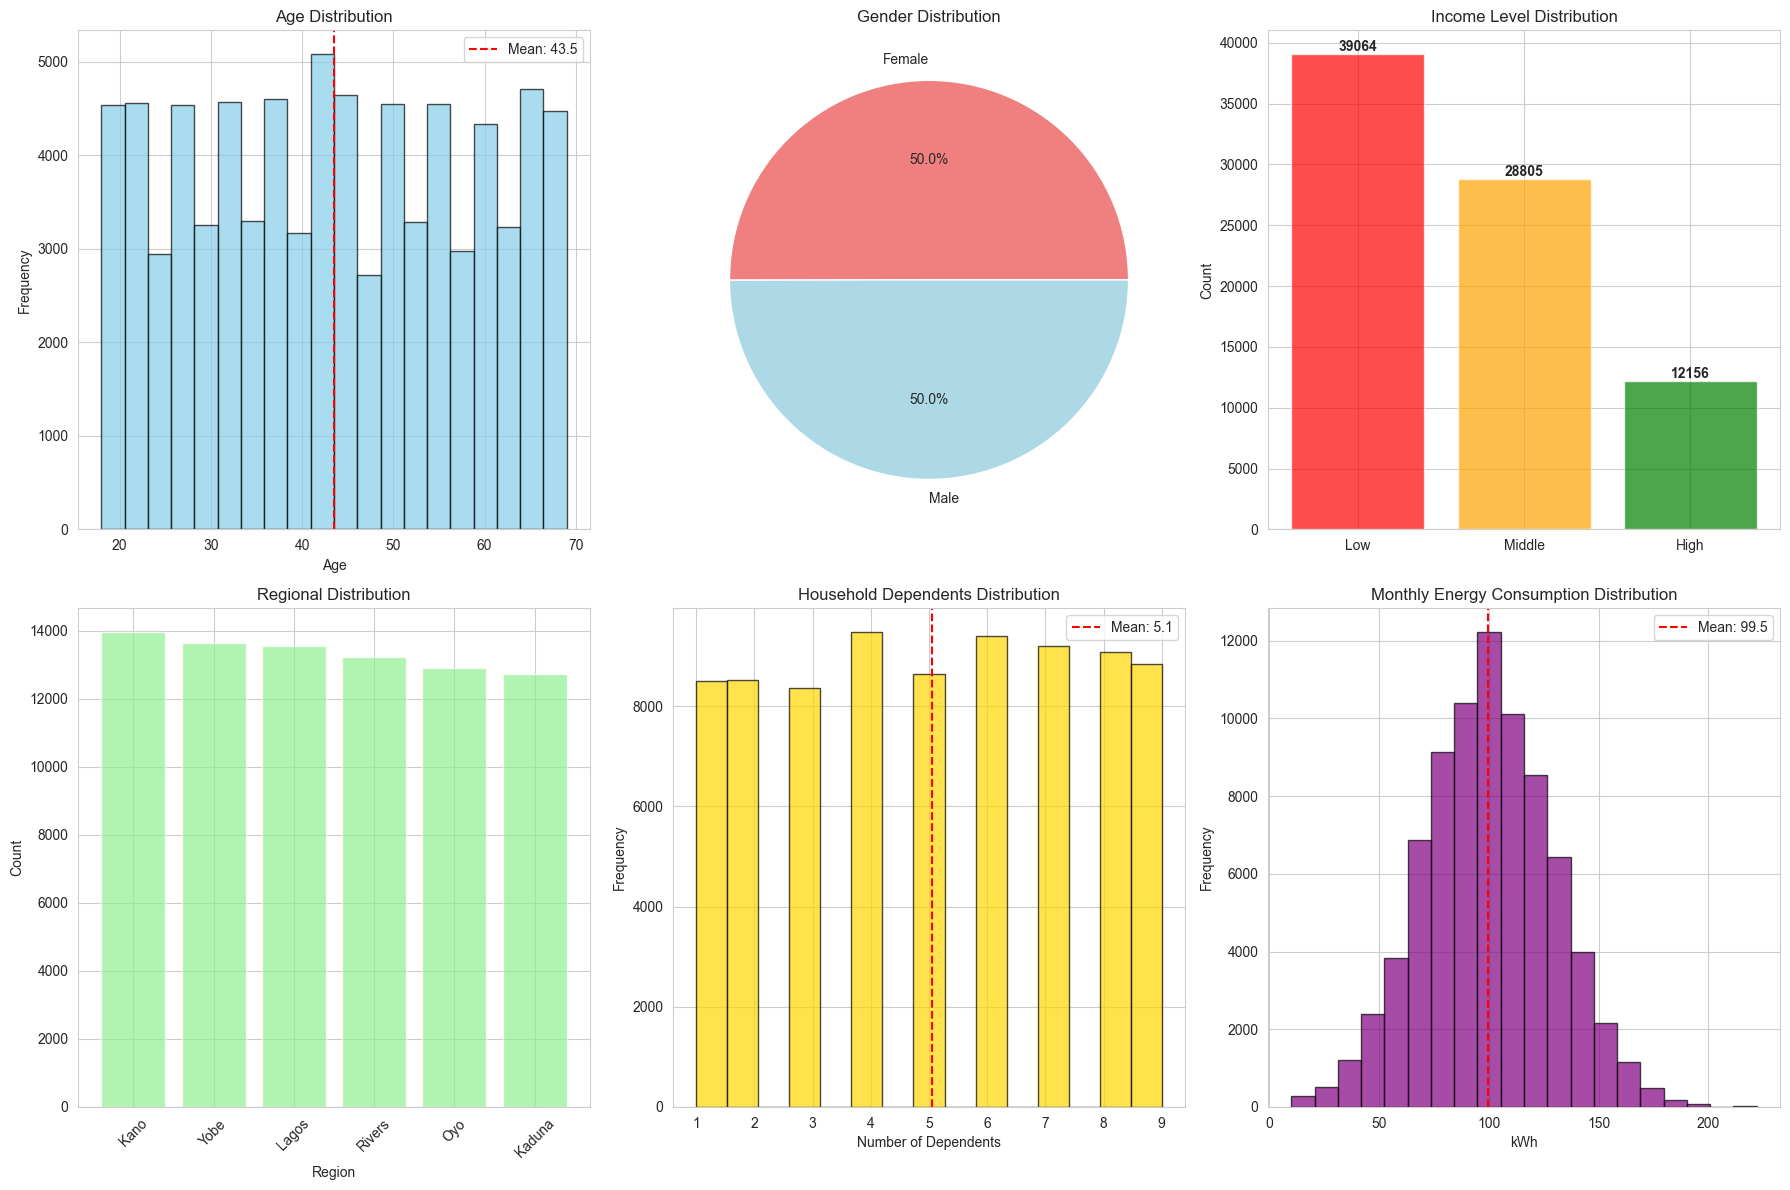

In [16]:
# Set plot style
sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Age Distribution
axes[0,0].hist(df['Age'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Age Distribution')
axes[0,0].set_xlabel('Age')
axes[0,0].set_ylabel('Frequency')
axes[0,0].axvline(df['Age'].mean(), color='red', linestyle='--', label=f'Mean: {df["Age"].mean():.1f}')
axes[0,0].legend()

# Age Distribution
gender_counts = df['Gender'].value_counts()
axes[0,1].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%', 
                colors=['lightcoral', 'lightblue'])
axes[0,1].set_title('Gender Distribution')

# Income level distribution
income_counts = df['Income_Level'].value_counts()
axes[0,2].bar(income_counts.index, income_counts.values, color=['red', 'orange', 'green'], alpha=0.7)
axes[0,2].set_title('Income Level Distribution')
axes[0,2].set_ylabel('Count')
for i, v in enumerate(income_counts.values):
    axes[0,2].text(i, v + 1, str(v), ha='center', va='bottom', fontweight='bold')

# Regional Distribution
region_counts = df['Region'].value_counts()
axes[1,0].bar(range(len(region_counts)), region_counts.values, color='lightgreen', alpha=0.7)
axes[1,0].set_title('Regional Distribution')
axes[1,0].set_xlabel('Region')
axes[1,0].set_ylabel('Count')
axes[1,0].set_xticks(range(len(region_counts)))
axes[1,0].set_xticklabels(region_counts.index, rotation=45)

# Household dependents distribution
axes[1,1].hist(df['Household_Dependents'], bins=15, alpha=0.7, color='gold', edgecolor='black')
axes[1,1].set_title('Household Dependents Distribution')
axes[1,1].set_xlabel('Number of Dependents')
axes[1,1].set_ylabel('Frequency')
axes[1,1].axvline(df['Household_Dependents'].mean(), color='red', linestyle='--', 
                    label=f'Mean: {df["Household_Dependents"].mean():.1f}')
axes[1,1].legend()

# Energy consumption distribution
axes[1,2].hist(df['Monthly_Energy_Consumption_kWh'], bins=20, alpha=0.7, color='purple', edgecolor='black')
axes[1,2].set_title('Monthly Energy Consumption Distribution')
axes[1,2].set_xlabel('kWh')
axes[1,2].set_ylabel('Frequency')
axes[1,2].axvline(df['Monthly_Energy_Consumption_kWh'].mean(), color='red', linestyle='--',
                    label=f'Mean: {df["Monthly_Energy_Consumption_kWh"].mean():.1f}')
axes[1,2].legend()
    
plt.tight_layout()
plt.show()

## Subsidy Distribution Patterns

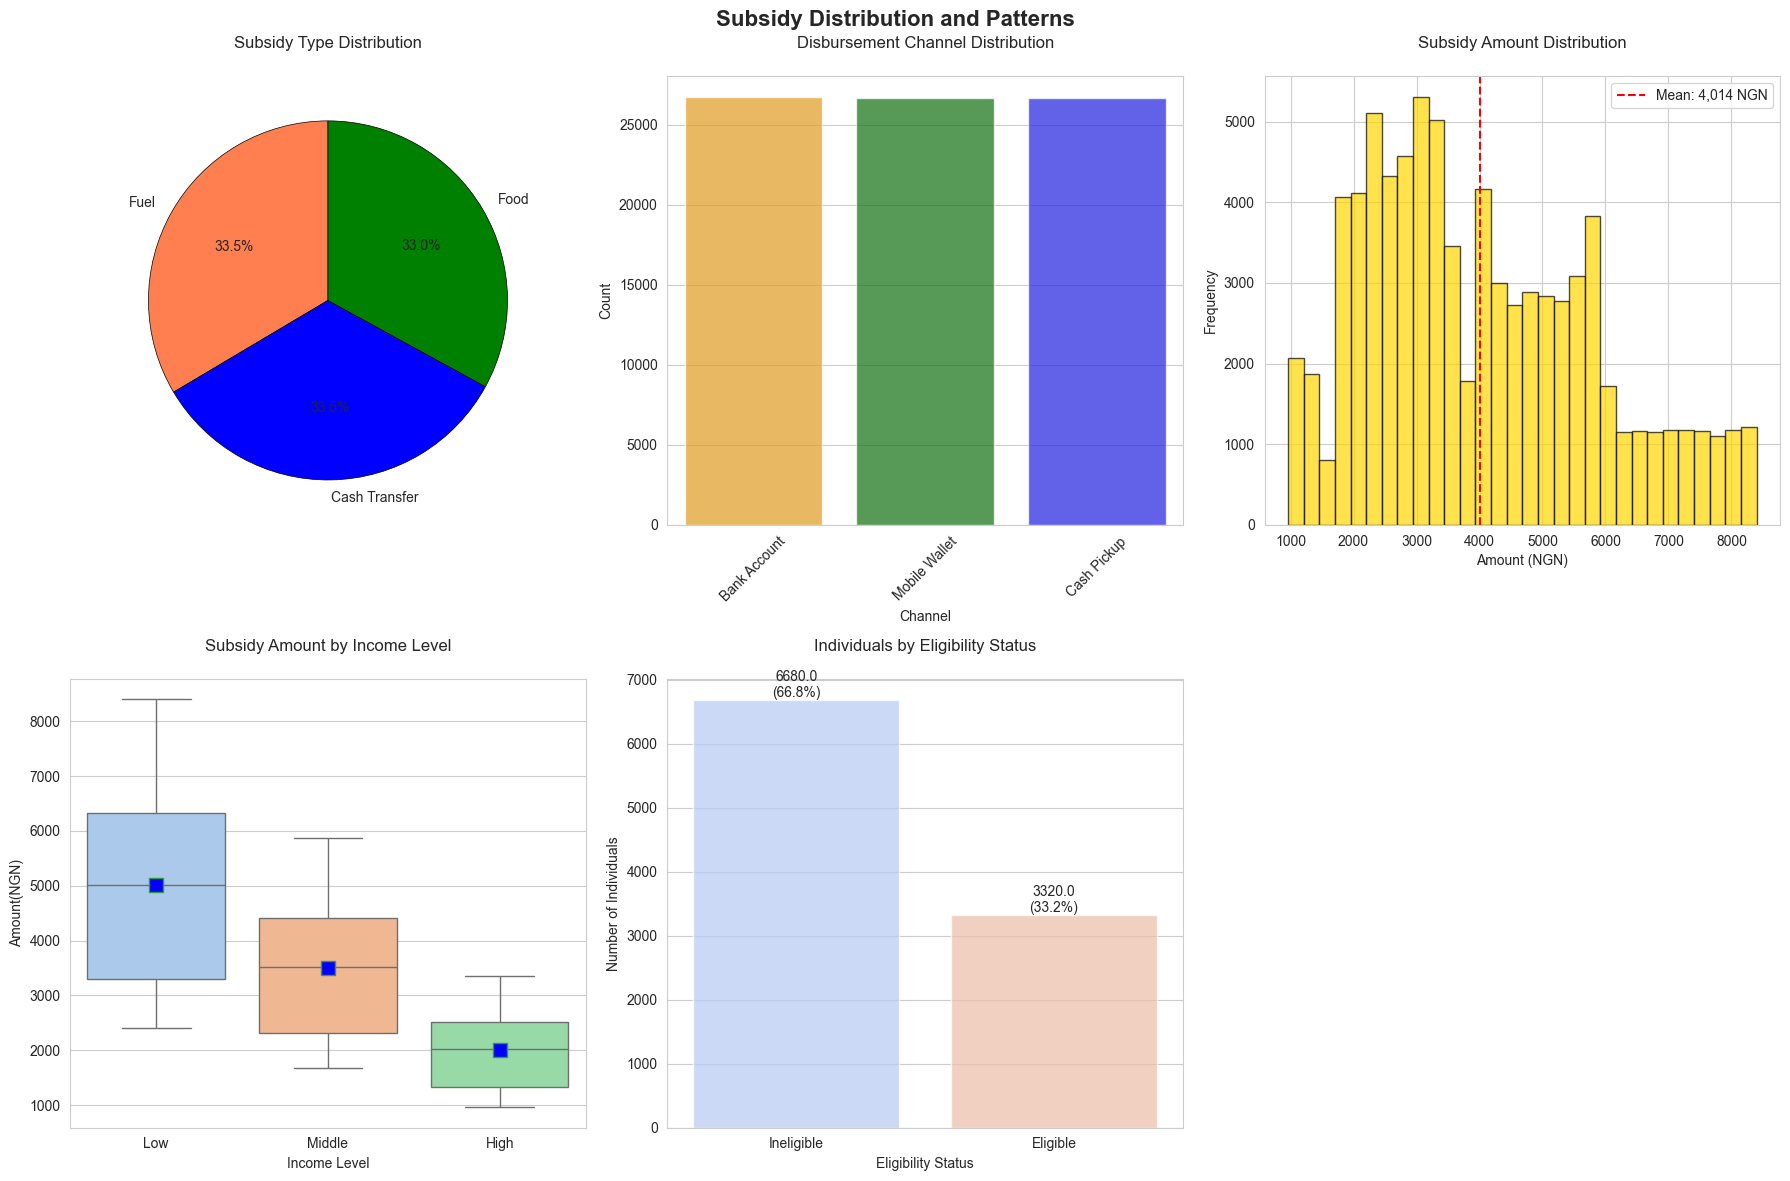

In [17]:
# Create subplots with adjusted layout
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Subsidy Distribution and Patterns', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.4, wspace=0.3) 

# Subsidy Type Distribution 
subsidy_counts = df['Subsidy_Type'].value_counts()
axes[0, 0].pie(
    subsidy_counts.values,
    labels=subsidy_counts.index,
    autopct='%1.1f%%',
    colors=['coral', 'blue', 'green'],
    startangle=90,
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5}
)
axes[0, 0].set_title('Subsidy Type Distribution', pad=20)

# Channel Distribution 
channel_counts = df['Channel'].value_counts()
sns.barplot(
    x=channel_counts.index,
    y=channel_counts.values,
    ax=axes[0, 1],
    palette=['orange', 'green', 'blue'],
    hue=channel_counts.index,
    legend=False,
    alpha=0.7
)
axes[0, 1].set_title('Disbursement Channel Distribution', pad=20)
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_xlabel('Channel')
axes[0, 1].tick_params(axis='x', rotation=45)

# --- Plot 3: Amount Distribution (Histogram) 
axes[0, 2].hist(
    df['Amount_NGN'],
    bins=30,
    alpha=0.7,
    color='gold',
    edgecolor='black'
)
axes[0, 2].set_title('Subsidy Amount Distribution', pad=20)
axes[0, 2].set_xlabel('Amount (NGN)')
axes[0, 2].set_ylabel('Frequency')
mean_amount = df['Amount_NGN'].mean()
axes[0, 2].axvline(
    mean_amount,
    color='red',
    linestyle='--',
    label=f'Mean: {mean_amount:,.0f} NGN'
)
axes[0, 2].legend()

# Income Level vs. Amount
income_order = ['Low', 'Middle', 'High']
df['Income_Level'] = pd.Categorical(
    df['Income_Level'],
    categories=income_order,
    ordered=True
)
sns.boxplot(
    data=df,
    x='Income_Level',
    y='Amount_NGN',
    ax=axes[1, 0],
    palette='pastel',
    hue='Income_Level',
    legend=False,
    showmeans=True,
    meanprops={"marker": "s", "markerfacecolor": "blue", "markersize": "10"},
    flierprops={"marker": "o", "markerfacecolor": "red", "markersize": "8"}
)
axes[1, 0].set_title('Subsidy Amount by Income Level', pad=20)
axes[1, 0].set_xlabel('Income Level')
axes[1, 0].set_ylabel('Amount(NGN)')

# Eligibility Status
eligibility_counts = df.groupby('Subsidy_Eligibility')['National_ID'].nunique()
eligibility_percentages = (eligibility_counts / eligibility_counts.sum()) * 100
eligibility_labels = {0: 'Ineligible', 1: 'Eligible'}

sns.barplot(
    x=eligibility_counts.index.map(eligibility_labels),
    y=eligibility_counts.values,
    ax=axes[1, 1],
    palette='coolwarm',
    hue=eligibility_counts.index.map(eligibility_labels),
    legend=False,
    alpha=0.7
)
axes[1, 1].set_title('Individuals by Eligibility Status', pad=20)
axes[1, 1].set_xlabel('Eligibility Status')
axes[1, 1].set_ylabel('Number of Individuals')

# Add count and percentage labels
for i, p in enumerate(axes[1, 1].patches):
    height = p.get_height()
    percentage = eligibility_percentages.iloc[i]
    axes[1, 1].text(
        p.get_x() + p.get_width() / 2.,
        height + 5,
        f'{height}\n({percentage:.1f}%)',
        ha='center',
        va='bottom',
        fontsize=10
    )

axes[1, 2].axis('off') 

plt.tight_layout()
plt.show()

#### Fraud Patterns

In [27]:
df_fraud = df[df['Suspected_Fraud'] == 1]
df_nf = df[df['Suspected_Fraud'] == 0]
df_fraud.head()

National_ID  Age  Gender  Region Income_Level  Household_Dependents  \
58      ID00006   25  Female  Kaduna       Middle                     4   
108     ID00012   28  Female  Rivers          Low                     6   
148     ID00016   41    Male    Yobe       Middle                     6   
173     ID00018   39    Male    Yobe          Low                     3   
178     ID00019   19  Female  Rivers       Middle                     1   

     Monthly_Energy_Consumption_kWh  Subsidy_Eligibility   Subsidy_Type  \
58                               86                    0  Cash Transfer   
108                              63                    1  Cash Transfer   
148                              73                    0  Cash Transfer   
173                              79                    0  Cash Transfer   
178                              88                    0  Cash Transfer   

     Amount_NGN        Channel       Date Wallet_Activity_Status  \
58         5290  Mobile Wallet 2020-09-18               Inactive   
108        8287  Mobile Wallet 2022-02-28             Suspicious   
148        5756  Mobile Wallet 2023-04-28               Inactive   
173        7458  Mobile Wallet 2019-12-29               Inactive   
178        5589  Mobile Wallet 2022-05-29             Suspicious   

     Wallet_Balance_NGN  Days_Since_Last_Transaction  \
58               6654.0                          8.0   
108              3309.0                         93.0   
148              3894.0                         62.0   
173              6418.0                         74.0   
178              2593.0                         64.0   

     Avg_Monthly_Wallet_Balance  Suspected_Fraud  
58                       4128.0                1  
108                      4918.0                1  
148                      2918.0                1  
173                      3735.0                1  
178                      3634.0                1

In [20]:
df_fraud.to_csv('fraud.csv')

Boxplot for Amount vs. Fraud saved as 'amount_fraud_boxplot.png'


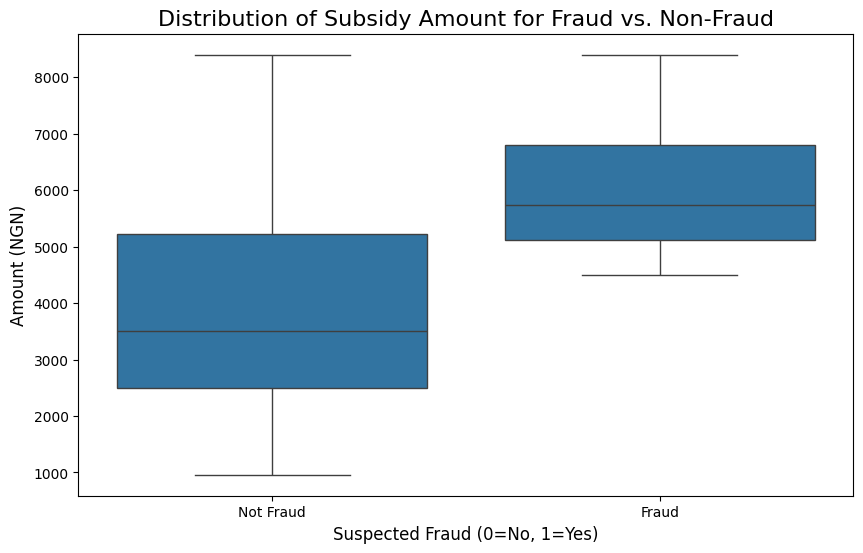

In [39]:
# Boxplot for Amount_NGN
plt.figure(figsize=(10, 6))
sns.boxplot(x='Suspected_Fraud', y='Amount_NGN', data=df)
plt.title('Distribution of Subsidy Amount for Fraud vs. Non-Fraud', fontsize=16)
plt.xlabel('Suspected Fraud (0=No, 1=Yes)', fontsize=12)
plt.ylabel('Amount (NGN)', fontsize=12)
plt.xticks([0, 1], ['Not Fraud', 'Fraud'])
plt.savefig('amount_fraud_boxplot.png')
print("Boxplot for Amount vs. Fraud saved as 'amount_fraud_boxplot.png'")

plt.show()

In [29]:
print(df_fraud.groupby('Subsidy_Type').size())

Subsidy_Type
Cash Transfer    1991
Fuel             1006
dtype: int64


In [26]:
print(df_fraud.groupby('Wallet_Activity_Status').size())

Wallet_Activity_Status
Active           0
Inactive      2035
No Wallet        0
Suspicious     962
dtype: int64


In [22]:
df_fraud.describe()

Age  Household_Dependents  Monthly_Energy_Consumption_kWh  \
count  2997.000000           2997.000000                     2997.000000   
mean     43.556223              5.021688                       98.351351   
min      18.000000              1.000000                       10.000000   
25%      31.000000              3.000000                       78.000000   
50%      43.000000              5.000000                       98.000000   
75%      56.000000              7.000000                      118.000000   
max      69.000000              9.000000                      216.000000   
std      14.949266              2.579419                       29.858361   

       Subsidy_Eligibility   Amount_NGN                           Date  \
count          2997.000000  2997.000000                           2997   
mean              0.513847  6003.181181  2021-06-29 08:06:14.774775040   
min               0.000000  4501.000000            2019-01-01 00:00:00   
25%               0.000000  5124.000000            2020-04-06 00:00:00   
50%               1.000000  5741.000000            2021-06-25 00:00:00   
75%               1.000000  6806.000000            2022-09-22 00:00:00   
max               1.000000  8399.000000            2023-12-31 00:00:00   
std               0.499892  1086.949494                            NaN   

       Wallet_Balance_NGN  Days_Since_Last_Transaction  \
count         2997.000000                  2997.000000   
mean          4967.999666                    49.584585   
min              0.000000                     0.000000   
25%           3639.000000                    24.000000   
50%           4930.000000                    50.000000   
75%           6326.000000                    74.000000   
max          11304.000000                    99.000000   
std           1963.488670                    28.950973   

       Avg_Monthly_Wallet_Balance  Suspected_Fraud  
count                 2997.000000           2997.0  
mean                  4031.654988              1.0  
min                      0.000000              1.0  
25%                   3000.000000              1.0  
50%                   4013.000000              1.0  
75%                   5087.000000              1.0  
max                   8864.000000              1.0  
std                   1506.970778              0.0

In [38]:
df_fraud

National_ID  Age  Gender  Region Income_Level  Household_Dependents  \
58        ID00006   25  Female  Kaduna       Middle                     4   
108       ID00012   28  Female  Rivers          Low                     6   
148       ID00016   41    Male    Yobe       Middle                     6   
173       ID00018   39    Male    Yobe          Low                     3   
178       ID00019   19  Female  Rivers       Middle                     1   
...           ...  ...     ...     ...          ...                   ...   
79898     ID09987   23  Female  Kaduna          Low                     7   
79931     ID09992   35  Female    Yobe       Middle                     7   
79951     ID09994   54  Female    Yobe          Low                     1   
79960     ID09995   41  Female    Kano       Middle                     6   
80005     ID09999   64    Male    Yobe          Low                     8   

       Monthly_Energy_Consumption_kWh  Subsidy_Eligibility   Subsidy_Type  \
58                                 86                    0  Cash Transfer   
108                                63                    1  Cash Transfer   
148                                73                    0  Cash Transfer   
173                                79                    0  Cash Transfer   
178                                88                    0  Cash Transfer   
...                               ...                  ...            ...   
79898                             146                    1  Cash Transfer   
79931                              95                    0  Cash Transfer   
79951                              78                    0           Fuel   
79960                              99                    0  Cash Transfer   
80005                             133                    1           Fuel   

       Amount_NGN        Channel       Date Wallet_Activity_Status  \
58           5290  Mobile Wallet 2020-09-18               Inactive   
108          8287  Mobile Wallet 2022-02-28             Suspicious   
148          5756  Mobile Wallet 2023-04-28               Inactive   
173          7458  Mobile Wallet 2019-12-29               Inactive   
178          5589  Mobile Wallet 2022-05-29             Suspicious   
...           ...            ...        ...                    ...   
79898        8111  Mobile Wallet 2019-02-26               Inactive   
79931        5317  Mobile Wallet 2020-02-28               Inactive   
79951        5888  Mobile Wallet 2021-03-20               Inactive   
79960        4733  Mobile Wallet 2023-01-18               Inactive   
80005        5134  Mobile Wallet 2023-02-23               Inactive   

       Wallet_Balance_NGN  Days_Since_Last_Transaction  \
58                 6654.0                          8.0   
108                3309.0                         93.0   
148                3894.0                         62.0   
173                6418.0                         74.0   
178                2593.0                         64.0   
...                   ...                          ...   
79898              3758.0                         56.0   
79931              2707.0                         14.0   
79951                 0.0                         50.0   
79960              5889.0                         46.0   
80005              5683.0                         28.0   

       Avg_Monthly_Wallet_Balance  Suspected_Fraud  
58                         4128.0                1  
108                        4918.0                1  
148                        2918.0                1  
173                        3735.0                1  
178                        3634.0                1  
...                           ...              ...  
79898                      3201.0                1  
79931                      2573.0                1  
79951                      4073.0                1  
79960                      3531.0                1  
80005                      1298.0  

In [28]:
print(df_nf['Amount_NGN'].mean())
print(df_nf['Amount_NGN'].max())
print(df_nf['Amount_NGN'].min())
print(df_fraud['Amount_NGN'].mean())
print(df_fraud['Amount_NGN'].max())
print(df_fraud['Amount_NGN'].min())

3936.9216518668536
8399
960
6003.181181181181
8399
4501


# Machine Learning

### Anomaly detection and supervised fraud prediction in the data

#### 1. Problem Understanding
We need to detect three types of suspicious patterns:
1. Ghost beneficiaries.
2. High subsidy with low need.
3. Duplicate patterns

We will use unsupervised detection using Isolation forest to find anomalies then compare with original labels. Secondly we will perform supervised learning  to detect fraud.


### Data Preprocessing

### Unsupervised Model: Isolation Forest

In [15]:
# Separate features and target
X = df.drop(['Suspected_Fraud', 'National_ID', 'Date'], axis=1)
y = df['Suspected_Fraud']

# Feature engineering
df['Subsidy_to_Income_Ratio'] = df['Amount_NGN'] / df['Income_Level'].map({'Low':1, 'Middle':2, 'High':3})
df['Ghost_Beneficiary'] = (df['Monthly_Energy_Consumption_kWh'] <= 0).astype(int)
df['Inactive_Wallet'] = (df['Wallet_Activity_Status'] != 'Active').astype(int)

# Define column types
categorical_features = ['Gender', 'Region', 'Income_Level', 'Subsidy_Type', 'Channel']
numerical_features = [
    'Age', 'Household_Dependents', 'Monthly_Energy_Consumption_kWh',
    'Amount_NGN', 'Subsidy_to_Income_Ratio', 'Ghost_Beneficiary', 'Inactive_Wallet'
]

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])

# Create complete pipeline with Isolation Forest
iso_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('iso', IsolationForest(
        contamination=0.0375, 
        n_estimators=300,
        random_state=42
    ))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train and predict
iso_pipe.fit(X_train)
anomaly_scores = iso_pipe.decision_function(X_test)
predictions = (anomaly_scores < np.percentile(anomaly_scores, 5)).astype(int)

# Evaluate
print("=== Isolation Forest Results ===")
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))
print("\nClassification Report:")
print(classification_report(y_test, predictions))

=== Isolation Forest Results ===
Confusion Matrix:
[[14613   793]
 [  591     8]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95     15406
           1       0.01      0.01      0.01       599

    accuracy                           0.91     16005
   macro avg       0.49      0.48      0.48     16005
weighted avg       0.93      0.91      0.92     16005



### Supervised Learning with Random Forest

Fitting 5 folds for each of 12 candidates, totalling 60 fits
=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15406
           1       1.00      1.00      1.00       599

    accuracy                           1.00     16005
   macro avg       1.00      1.00      1.00     16005
weighted avg       1.00      1.00      1.00     16005


=== Confusion Matrix ===
[[15406     0]
 [    1   598]]
ROC-AUC: 1.0000


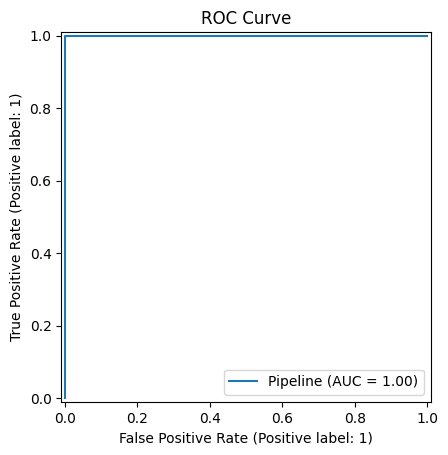

In [16]:
smote = SMOTE(sampling_strategy=0.2, random_state=42)
model = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('classifier', RandomForestClassifier(
        class_weight='balanced',  # Penalizes misclassifying fraud
        random_state=42,
        n_jobs=-1  # Uses all CPU cores
    ))
])

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10, None],
    'classifier__min_samples_leaf': [1, 5]
}

grid_search = GridSearchCV(
    model, 
    param_grid, 
    cv=5,  # 5-fold cross-validation
    scoring='f1',  # Optimizes for F1-score
    verbose=1
)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("=== Classification Report for Random Forest ===")
print(classification_report(y_test, y_pred))

print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))


y_proba = best_model.predict_proba(X_test)[:, 1]  # Fraud probabilities
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")

# Plot ROC curve
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title('ROC Curve')
plt.show()

In [72]:
subsidy_clean.to_csv('subsidy_clean.csv', index=False)